<h2> Lab 4 : Abnormal heartbeat detection with LSTMs and CNNs </h2>

Today, detecting abnormal heartbeat patterns is important in smartwatches.
In this lab, we will try to predict heart arrhythmia with LSTMs and 1-D CNNs.

We will use MIT-BIH Arrythmia dataset (https://www.physionet.org/content/mitdb/1.0.0/).
It consists of ECG recordings of several patients (patient IDs being 100, 101, etc.) with sampling frequency of 360 (samples/sec). Experts annotated/classified specific points in the signals as normal, abnormal, or non beat.

**NOTE1:** GPU is required for this lab.
You must change "Runtime type" to GPU from the "Runtime" tab ("Change Runtime type").

NOTE2: If you face RAM/memory overflow issue in this lab, ensure that you train only one model in single COLAB session. Feel free to implement your own memory optimization tricks too.

In [1]:
# load libraries (feel free to add more) and get dataset
import os
%pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal

from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D  # https://keras.io/api/layers/convolution_layers/convolution1d/
from keras.layers import LeakyReLU

from pywt import wavedec, dwt   # https://pywavelets.readthedocs.io/

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

urllib.request.urlretrieve('https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip', './mba_dataset.zip')
!unzip mba_dataset.zip -d mba_dataset
path_dataset='mba_dataset/mit-bih-arrhythmia-database-1.0.0/'

Archive:  mba_dataset.zip
replace mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.atr? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102-0.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.hea  
  inflating: mba_dataset/mit-bih-arrhythm

**Exploring the data**

Do `!ls mba_dataset/mit-bih-arrhythmia-database-1.0.0` to see the files present in dataset. We will primarily use \<patientID>.atr files. There are 48 patients with a 30 minutes of recording for each.
For '100' patient, let us check what all annotations are present in his/her signal. Run the code below.

In [2]:
!ls mba_dataset/mit-bih-arrhythmia-database-1.0.0
annotation = wfdb.rdann(os.path.join(path_dataset, '100'), 'atr')
print(annotation.symbol)  # symbols present in the data for patient 100

100.atr    106.dat  113.hea  119.hea  202.atr  209.xws	217.xws  230.atr
100.dat    106.hea  113.xws  119.xws  202.dat  210.atr	219.atr  230.dat
100.hea    106.xws  114.atr  121.atr  202.hea  210.dat	219.dat  230.hea
100.xws    107.atr  114.dat  121.dat  202.xws  210.hea	219.hea  230.xws
101.atr    107.dat  114.hea  121.hea  203.at_  210.xws	219.xws  231.atr
101.dat    107.hea  114.xws  121.xws  203.at-  212.atr	220.atr  231.dat
101.hea    107.xws  115.atr  122.atr  203.atr  212.dat	220.dat  231.hea
101.xws    108.at_  115.dat  122.dat  203.dat  212.hea	220.hea  231.xws
102-0.atr  108.atr  115.hea  122.hea  203.hea  212.xws	220.xws  232.atr
102.atr    108.dat  115.xws  122.xws  203.xws  213.atr	221.atr  232.dat
102.dat    108.hea  116.atr  123.atr  205.atr  213.dat	221.dat  232.hea
102.hea    108.xws  116.dat  123.dat  205.dat  213.hea	221.hea  232.xws
102.xws    109.atr  116.hea  123.hea  205.hea  213.xws	221.xws  233.atr
103.atr    109.dat  116.xws  123.xws  205.xws  214.at_	222.at_  

We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
We provide below the list of symbols which we will consider as "abnormal" beats in this lab.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For detailed explanation about symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [3]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [4]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input: path for patient files (excluding extension)
    Output: ECG signal, symbols (labels), indices for such symbols
    '''
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:,0]    # ECG signal
    symbol = annotation.symbol  # symbols
    index = annotation.sample  # annotation index
    return signal, symbol, index
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, '100'))  # check for yourself "signal" is ~30 min duration
print(f'Length of signal: {len(signal)}')  # ECG signal length (in terms of samples and NOT seconds); think why this corresponds to ~30 minutes of signal
print(f'Annotation symbols: {symbol}')  # annotation symbold
print(f'Annotation indices: {index}')  # annotion indices for patient 100 
print(f'Sample# {index[8]} has symbol marked as {symbol[8]} which refers to abnormal beat')  # sample 2044 is abnormal

Length of signal: 650000
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

Index contains the time in which we have a heart beat. In our case, we will use those indices as values obtained from a heartbeat detector for simplicity. For more information about heartbeat detection, you can visit https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm

**TASK 1 (10 points)**: Plot any random 10-second long portion of this ECG file. Then plot any 1-second portion which has an abnormality approximately in the middle of the signal.

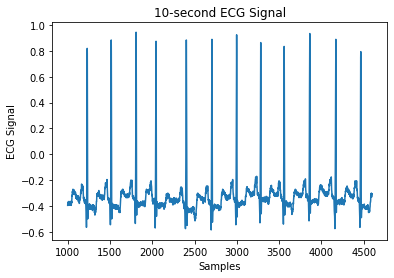

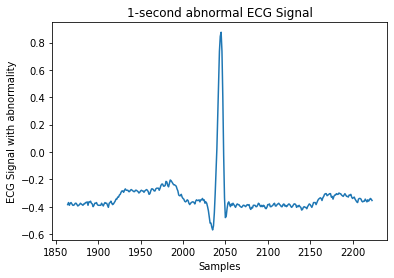

In [5]:
SR=360 # Sampling rate - 360 samples/second

# Plotting 10 second long portion starting from 1000th sample
Time_Interval_for_plotting=10 # Time In Seconds
Total_Samples=SR*Time_Interval_for_plotting 
Start=1000 # Randomly choosen
End=Start+Total_Samples
plt.plot(list(range(Start,End)),signal[Start:End])
plt.title('10-second ECG Signal')
plt.xlabel('Samples')
plt.ylabel('ECG Signal')
plt.show()


# Plotting 1- second portion - signal with abnormality - position abnormality in approx middle
Time_Interval_for_plotting=1 # Time In Seconds
Total_Samples=SR*Time_Interval_for_plotting 
Sample_Index_Of_Abnormality=index[8] #Choosing it from data printed above
Start=Sample_Index_Of_Abnormality-int((Time_Interval_for_plotting/2)*SR) #Putting the abnormal signal at 0.5 second from start - making it middle of 1 sec 
End=Start+Total_Samples
plt.plot(list(range(Start,End)),signal[Start:End])
plt.title('1-second abnormal ECG Signal')
plt.xlabel('Samples')
plt.ylabel('ECG Signal with abnormality')
plt.show()


**TASK 2 (20 points)**: (Data Preparation) Training data is usually represented by a matrix $X \in \mathbb{R}^{N\times D}$. N is the number of training points. D is the data dimension. We will consider one data point as +/- 3 seconds sequence of samples centered around a normal or abnormal symbol. Therefore, $D=6f$, where $f$ is the sampling frequency. Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. You should get close to a total of 100k data points. Do not forget to ignore non-beat symbols.

The patients for training set should be different from the ones in test set. Roughly divide the patients into 70:30 ratio or you may simply use the patient IDs already divided into train/test below.

In [6]:
# training patient IDs
pts_train = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210']

# testing patient IDs
pts_test = ['212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']


def make_dataset(Patients,Time_to_middle_with):
  '''
  Output: X_train, y_train, X_test y_test - changing output to return only X and Y -> for reusing same function for Train and Test
  '''
  #Creating empty arrays
  X_out=[]
  y_out=[]

  for patient in Patients: #Looping through each patient
    p_signal, p_symbol, p_index = load_ECG_file(os.path.join(path_dataset,patient)) #Getting signal,symbol,index from each patient

    for i,symbol in enumerate(p_symbol):
      if symbol in abnormal: #Checking if Symbol is one of abnormals - Other symbols excluded
        Start=p_index[i]-(Time_to_middle_with*SR)
        End=Start+(2*Time_to_middle_with*SR)
        if Start>=0 and End<=len(p_signal): #Excluding signals which cannot be middled with given time
          Sig=p_signal[Start:End] #clipping the 3second signal for each signal
          X_out.append(Sig) 
          y_out.append(1) #Appending 1 if abnormal

      elif symbol=='N': #Checking if Symbol is normal
        Start=p_index[i]-(Time_to_middle_with*SR)
        End=Start+(2*Time_to_middle_with*SR)
        if Start>=0 and End<=len(p_signal):  #Excluding signals which cannot be middled with given time
          Sig=p_signal[Start:End] #clipping the 3second signal for each signal
          X_out.append(Sig)
          y_out.append(0) #appending 0 if normal

  #Converting list to np array and returning them 
  return np.array(X_out),np.array(y_out)

#Calling the make dataset function
X_train,y_train=make_dataset(pts_train,3) # 3 indicates 3 seconds is the middling time
X_test,y_test=make_dataset(pts_test,3)

#Checking if we are getting expected dimensions
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(70187, 2160)
(38912, 2160)
(70187,)
(38912,)


**TASK 3 (20 points)**: (Feature Extraction) You will use pywt wavelet library to extract features for training and testing data matrices. We will do "Multilevel 1D Discrete Wavelet Transform". Daubechies dB6 wavelet is used specifically. Number of level of decompositions (called levels) is chosen to be 4. It is a hyper-parameter which is determined based on nature of signal of interest. It is highly recommended to go through the following paper. It explains how Wavelet Transform is suited for signals localized in time and frequency:

'Güler, Inan, and Elif Derya Übeylı. "ECG beat classifier designed by combined neural network model." Pattern recognition 38.2 (2005): 199-208.'

Following is a hint on how you will extract features for a signal:

In [7]:
signal = np.random.random((10000,))
signal = scipy.signal.decimate(signal, 2)   # downsampling by 2 to reduce memory usage
features = wavedec(signal, 'db6', level=4)
print('Note that you get a list of features with shapes:', [_.shape for _ in features])

Note that you get a list of features with shapes: [(322,), (322,), (634,), (1258,), (2505,)]


The wavedec function calculates the discrete wavelet transform,

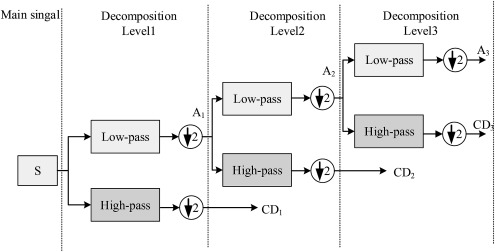

You have to do zero-padding on these features to make them equal length. Then, stack them along a new axis to finally obtain a 2D matrix ($S \times 5$) of features per signal.

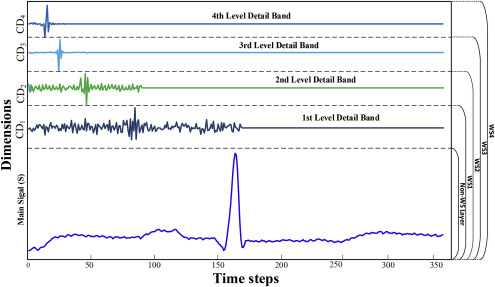

For more details, read the paper: [A novel wavelet sequence based on deep bidirectional LSTM network model for ECG signal classification](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA)

In [8]:
# CODE HERE
def extract_features(X):
  '''
  Input: X (N x D): Input data matrix
  Output: F (N x S x 5): Feature matrix
  '''
  Fil=[] #empty list to fill with 0 padded features for each record
  for signal in X:
    signal = scipy.signal.decimate(signal, 2)   # downsampling by 2 to reduce memory usage
    features = wavedec(signal, 'db6', level=4)
    padded_all=[]
    for f in features:
        padded_feature = np.pad(f, (0,len(features[-1])-len(f)), 'constant') #0 padding all small dimension features into the dimension of largest features
        #print(padded_feature.shape)
        padded_all.append(padded_feature)

    #Making the extracted features as 545 x 5 dimensional numpy array
    K=np.swapaxes(np.array(padded_all),0,1)
    Fil.append(K)

  #Converting list to numpy array
  F=np.array(Fil)
  return F
  
F_train = extract_features(X_train)
F_test = extract_features(X_test)
print(F_train.shape, F_test.shape)

(70187, 545, 5) (38912, 545, 5)


**TASK 4 (20 points)**: Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA). 
Using Keras, create a single layer Bidirectional LSTM model. Choose number of output units of LSTM equals to 32. Followed by LSTM layer, you should have a dense layer with sigmoid activation and number of output units equals to 1. The model should be trained for few epochs with optimizer as Adam, loss as BCE (Binary Cross Entropy), and the metric used should be accuracy. Report your accuracy on test set.

Hint on training command: `model.fit(F_train, y_train, batch_size = ..., epochs=..., verbose = 1)`


In [9]:
# CODE HERE
model = Sequential()
model.add(Bidirectional(LSTM(32), input_shape=(F_train.shape[1],F_train.shape[2])))
model.add(Dense(1, activation = 'sigmoid'))
# compile the model - use binary crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.fit(F_train, y_train, batch_size = 32, epochs= 5, verbose = 1)
#Accuracy for test data
print("\nEvalauating model for Test Dataset\n")
model.evaluate(F_test, y_test, verbose=1)

Epoch 1/5
2194/2194 [==============================] - 367s 165ms/step - loss: 0.4804 - accuracy: 0.7705
Epoch 2/5
2194/2194 [==============================] - 361s 164ms/step - loss: 0.3157 - accuracy: 0.8621
Epoch 3/5
2194/2194 [==============================] - 360s 164ms/step - loss: 0.3392 - accuracy: 0.8517
Epoch 4/5
2194/2194 [==============================] - 359s 164ms/step - loss: 0.2512 - accuracy: 0.8967
Epoch 5/5
2194/2194 [==============================] - 358s 163ms/step - loss: 0.2131 - accuracy: 0.9163

Evalauating model for Test Dataset

1216/1216 [==============================] - 81s 66ms/step - loss: 0.7456 - accuracy: 0.7205


[0.7456162571907043, 0.7205489277839661]

In [10]:
# run this if you wish to print details on the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


You will find that this particular LSTM gives only 67-75% of test accuracy (depending on your implementation), which is close to random for our setup (due to data imbalance). We will move on to a superior model (for our setup) and code 1D CNNs. Note that performance of machine learning system depends on various factors like availability of data, choice of model, data processing, model size, etc.

**TASK 5 (20 points)**: (1-D CNNs) Different to LSTM model, we will have 1D CNN layer this time with 32 filters, kernel size of 5 and ReLU activation. You will add a flattening layer just after this (and before dense layer). CNN examples for Keras can easily be found online. Report test accuracy.

In [11]:
# CODE HERE
# model = Sequential()
# model.add ...
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(F_train.shape[1],F_train.shape[2])))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.fit(F_train, y_train, batch_size = 32, epochs= 5, verbose = 1)
#Accuracy for test data
print("\nEvaluating model for Test Dataset\n")
model.evaluate(F_test, y_test, verbose=1)

Epoch 1/5
2194/2194 [==============================] - 14s 5ms/step - loss: 0.1505 - accuracy: 0.9521
Epoch 2/5
2194/2194 [==============================] - 10s 5ms/step - loss: 0.0751 - accuracy: 0.9796
Epoch 3/5
2194/2194 [==============================] - 10s 5ms/step - loss: 0.0591 - accuracy: 0.9845
Epoch 4/5
2194/2194 [==============================] - 10s 5ms/step - loss: 0.0499 - accuracy: 0.9865
Epoch 5/5
2194/2194 [==============================] - 10s 5ms/step - loss: 0.0439 - accuracy: 0.9876

Evalauating model for Test Dataset

1216/1216 [==============================] - 4s 3ms/step - loss: 0.4522 - accuracy: 0.8348


[0.45219364762306213, 0.8347553610801697]

**TASK 6 (10 points)**: (Deep CNNs) Repeat the previous task by replacing the single convolutional layer with two of them, thereby making the model deeper. Comment on what differences you observe w.r.t. Task 5.

In [12]:
# CODE HERE
# model = Sequential()
# model.add ...
model =Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(F_train.shape[1],F_train.shape[2])))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.fit(F_train, y_train, batch_size = 32, epochs= 5, verbose = 1)
#Accuracy for test data
print("\nEvaluating model for Test Dataset\n")
model.evaluate(F_test, y_test, verbose=1)

Epoch 1/5
2194/2194 [==============================] - 15s 6ms/step - loss: 0.1203 - accuracy: 0.9617
Epoch 2/5
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0515 - accuracy: 0.9857
Epoch 3/5
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0374 - accuracy: 0.9892
Epoch 4/5
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0291 - accuracy: 0.9915
Epoch 5/5
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0227 - accuracy: 0.9932

Evalauating model for Test Dataset

1216/1216 [==============================] - 4s 3ms/step - loss: 0.6734 - accuracy: 0.8349


[0.6733717918395996, 0.8349352478981018]

With CNNs, your training accuracy should be above 95% and testing accuracy should be above 80%.

**TASK 7 (BONUS) (+20 points)**:


Propose another network architecture using Keras to classify between normal and abnormal (You can use papers like this to find inspiration: https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA)
State the reasoning behind your choice and report accuracy on test set.

OR

Use CNN to classify between the different classes indicated in abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S'].
Report balanced accuracy score on the test set: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


**You are ready to submit in Blackboard!**

Please suffix your colab file with `_<jhID>`
For	eg: Lab4_LSTM_CNNarrhythmia_myjhID12

In [13]:
#CNN Approach to classify between different classes

# Re-Making Y train and Y Test - to have Y labels to hold integers representing each classes

# Get Y Label - corresponding index
def get_abnormal_Label(a):
  for i,sym in enumerate(abnormal):
    if sym==a: #One of them will definitely be abnormal because we check that condition already
      return i+1 #Normal is 0 and  abnormal starts from 1 
  return -1 #If needed to have some error catching scenarios in future


def Bonus_Make_Y(patients):
  #Creating empty arrays
  # Taking X -( signal ) also because we remove signals which cannot be middled by 3 seconds and corresponding Y lable should also be removed  
  y_bonus=[]
  #Creating Training dataset
  for patient in patients:
    p_signal, p_symbol, p_index = load_ECG_file(os.path.join(path_dataset,patient)) #Getting signal,symbol,index from each patient
    for i,symbol in enumerate(p_symbol):
      if symbol in abnormal: #Checking if Symbol is one of abnormals - Other symbols excluded
        Start=p_index[i]-(3*SR)
        End=Start+(6*SR)
        if Start>=0 and End<=len(p_signal):
          y_bonus.append(get_abnormal_Label(symbol))

      elif symbol=='N': #Checking if Symbol is normal
        Start=p_index[i]-(3*SR)
        End=Start+(6*SR)
        if Start>=0 and End<=len(p_signal):
          y_bonus.append(0)

  return np.array(y_bonus)


#Calling the  bonus make y  function
y_bonus_train=Bonus_Make_Y(pts_train)
y_bonus_test=Bonus_Make_Y(pts_test)

print(y_bonus_train.shape)
print(y_bonus_test.shape)

(70187,)
(38912,)


In [14]:
# Making y labels into categorical trainable format 
import tensorflow as tf
y_bonus_multiclass_train = tf.keras.utils.to_categorical(y_bonus_train, num_classes=(len(abnormal)+1))
y_bonus_multiclass_test = tf.keras.utils.to_categorical(y_bonus_test, num_classes=(len(abnormal)+1))

In [15]:
#Building the model
model =Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(F_train.shape[1],F_train.shape[2])))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense((len(abnormal)+1), activation='softmax')) #Having a softmax layer - probability distribution across total number of classes
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy']) #Using loss as categorical cross entropy
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 541, 32)           832       
                                                                 
 conv1d_4 (Conv1D)           (None, 537, 32)           5152      
                                                                 
 flatten_2 (Flatten)         (None, 17184)             0         
                                                                 
 dense_3 (Dense)             (None, 14)                240590    
                                                                 
Total params: 246,574
Trainable params: 246,574
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Training the model 
model.fit(F_train, y_bonus_multiclass_train, batch_size = 32, epochs= 5, verbose = 1) # 5 epochs fixed after trial and error

Epoch 1/5
2194/2194 [==============================] - 16s 7ms/step - loss: 0.1536 - accuracy: 0.9617
Epoch 2/5
2194/2194 [==============================] - 15s 7ms/step - loss: 0.0526 - accuracy: 0.9872
Epoch 3/5
2194/2194 [==============================] - 15s 7ms/step - loss: 0.0342 - accuracy: 0.9911
Epoch 4/5
2194/2194 [==============================] - 15s 7ms/step - loss: 0.0240 - accuracy: 0.9931
Epoch 5/5
2194/2194 [==============================] - 15s 7ms/step - loss: 0.0160 - accuracy: 0.9954


In [17]:
#Testing the model
print("\nTest Accuracy and metrics:\n")
model.evaluate(F_test, y_bonus_multiclass_test, verbose=1)


Test Accuracy and metrics:

1216/1216 [==============================] - 5s 4ms/step - loss: 2.7548 - accuracy: 0.7592


[2.754800796508789, 0.7591745257377625]

In [18]:
#Balanced Accuracy score printing
from sklearn.metrics import balanced_accuracy_score
predicted_y = model.predict(F_test)
Predicted_labels=np.argmax(predicted_y,axis=1)
bas=balanced_accuracy_score(y_bonus_test, Predicted_labels)
print("Balanced Accuracy Score is "+str(bas)) #Warning generated - indcating class imbalance in test set on comparison with train

Balanced Accuracy Score is 0.25610462049577887


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Other Bonus : Proposing other model from keras 

Proposed Model :Using Resnet model for this classification task

Reason: Even though LSTM,GRU,RNN networks are most widely used in analyzing time series data, CNN based networks like resnet are preferred in classification tasks. The usage of networks like resnet will allow us in the future to build other parallel models like heart beat or blood velocity detections etc using transfer learning techniques. This representation will also help us to study reasons on why certain events are happening based on which part of networks are activated.

Major Reason: Trying to use Renet because resnets are popular in image classifications, so classifications in signals could also be a good application


In [19]:
# Generating the model - resnet
from tensorflow import keras 
def get_resnet_model():
  def residual_block(X, kernels, stride): #One block of resnet - we can use the function to build multiple renet blocks 
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5 #Moving the convolution kernel in steps of 5 samples 

  #Making 5 resblocks and then having a flatten layer followed by two dense layers - following used architectures
  inputs = keras.layers.Input((F_train.shape[1],F_train.shape[2])) #Setting the input shape to match our shape
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = keras.layers.Dense(1, activation='sigmoid')(X) #Sigmoid since we classifying only normal or abnormal

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [20]:
#building the model
model = get_resnet_model() 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
#Training the model
model.fit(F_train, y_train, batch_size = 32, epochs= 5, verbose = 1)
#Accuracy for test data
print("\nEvaluating model for Test Dataset\n")
model.evaluate(F_test, y_test, verbose=1)

Epoch 1/5
2194/2194 [==============================] - 34s 14ms/step - loss: 0.1243 - accuracy: 0.9542
Epoch 2/5
2194/2194 [==============================] - 30s 13ms/step - loss: 0.0527 - accuracy: 0.9838
Epoch 3/5
2194/2194 [==============================] - 35s 16ms/step - loss: 0.0389 - accuracy: 0.9877
Epoch 4/5
2194/2194 [==============================] - 40s 18ms/step - loss: 0.0332 - accuracy: 0.9892
Epoch 5/5
2194/2194 [==============================] - 31s 14ms/step - loss: 0.0278 - accuracy: 0.9911

Evalauating model for Test Dataset

1216/1216 [==============================] - 8s 6ms/step - loss: 1.2888 - accuracy: 0.8059


[1.2888405323028564, 0.8058696389198303]